In [ ]:
! pip install -q ISR

     |████████████████████████████████| 86.3MB 50kB/s 
     |████████████████████████████████| 3.8MB 50.4MB/s 
     |████████████████████████████████| 450kB 50.2MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from PIL import Image

img = Image.open('drive/MyDrive/COMP5900/data/centered_scale-1-over-4/000224.png')
# img = img.resize((200, 200), Image.BILINEAR)
lr_img = np.array(img)[:,:,:3]
print(lr_img.shape)
full = Image.open('drive/MyDrive/COMP5900/data/centered/000224.png')

(100, 100, 3)


17465344/17462488 [==============================] - 1s 0us/step


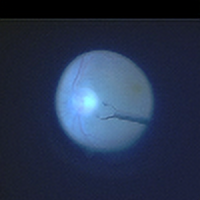

In [ ]:
from ISR.models import RDN, RRDN

# rdn = RDN(weights='psnr-large')
# rdn = RDN(weights='noise-cancel')
rdn = RDN(weights='psnr-small')
rrdn = RRDN(weights='gans')
rdn.scale = 8
sr_img = rdn.predict(lr_img[:,:,:3])

Image.fromarray(sr_img)

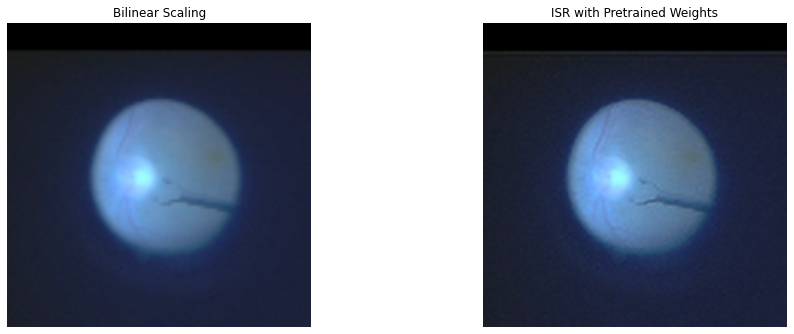

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
bilinear = img.resize((400, 400), Image.BILINEAR)
plt.imshow(bilinear)
plt.axis('off')
plt.title('Bilinear Scaling')

plt.subplot(1, 2, 2)
lr_img = np.array(img)[:,:,:3]
pred = rdn.predict(lr_img)
pred = Image.fromarray(pred).resize((400, 400), Image.BILINEAR)
plt.imshow(pred)
plt.axis('off')
plt.title('ISR with Pretrained Weights')
plt.tight_layout(pad=2)
plt.savefig('pretrained-weights.png')


In [ ]:
lr_img.shape

(100, 100, 3)

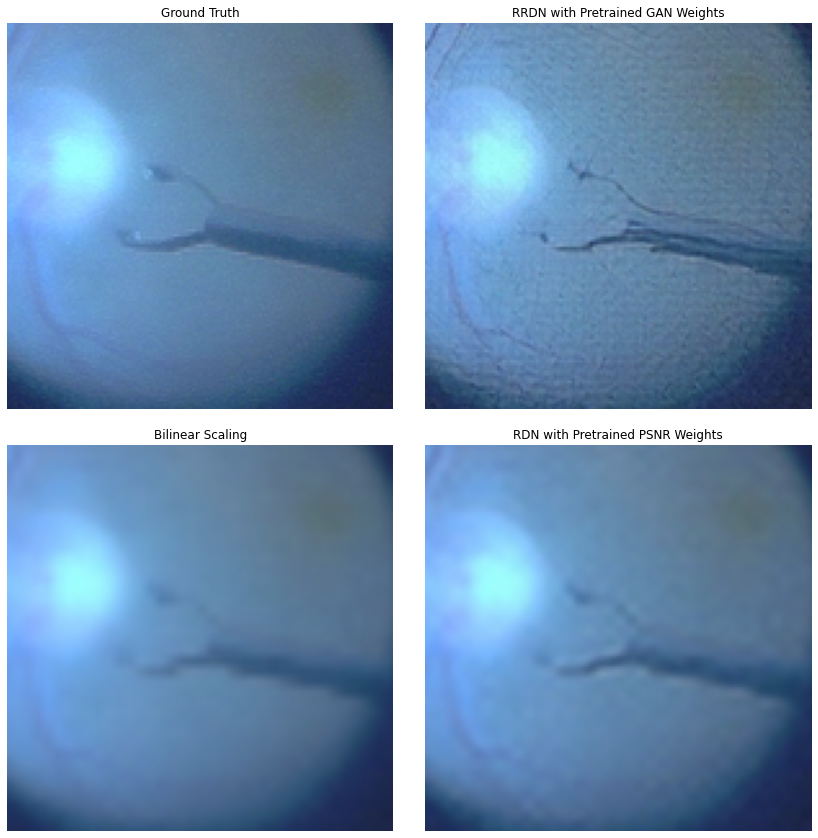

In [ ]:
import matplotlib.pyplot as plt

lr_img = np.array(img)[:,:,:3]

plt.figure(figsize=(12,12))

plt.subplot(2, 2, 3)
bilinear = img.resize((400, 400), Image.BILINEAR)
plt.imshow(np.array(bilinear)[150:300, 150:300])
plt.axis('off')
plt.title('Bilinear Scaling')

plt.subplot(2, 2, 2)
pred = rrdn.predict(lr_img)
pred = Image.fromarray(pred).resize((400, 400), Image.BILINEAR)
pred = np.array(pred)
plt.imshow(pred[150:300, 150:300])
plt.axis('off')
plt.title('RRDN with Pretrained GAN Weights')

plt.subplot(2, 2, 4)
pred = rdn.predict(lr_img)
pred = Image.fromarray(pred).resize((400, 400), Image.BILINEAR)
pred = np.array(pred)
plt.imshow(pred[150:300, 150:300])
plt.axis('off')
plt.title('RDN with Pretrained PSNR Weights')

plt.subplot(2, 2, 1)
plt.imshow(np.array(full)[150:300, 150:300])
plt.axis('off')
plt.title('Ground Truth')


plt.tight_layout(pad=2)
plt.savefig('pretrained-weights-close.png')

# Train

In [ ]:
from ISR.models import RRDN
from ISR.models import Discriminator
from ISR.models import Cut_VGG19

lr_train_patch_size = 40
layers_to_extract = [5, 9]
scale = 4
hr_train_patch_size = lr_train_patch_size * scale

rrdn  = RRDN(arch_params={'C':4, 'D':3, 'G':64, 'G0':64, 'T':10, 'x':scale}, patch_size=lr_train_patch_size)
f_ext = Cut_VGG19(patch_size=hr_train_patch_size, layers_to_extract=layers_to_extract)
discr = Discriminator(patch_size=hr_train_patch_size, kernel_size=3)

In [ ]:
from ISR.train import Trainer
loss_weights = {
  'generator': 0.0,
  'feature_extractor': 0.0833,
  'discriminator': 0.01
}
losses = {
  'generator': 'mae',
  'feature_extractor': 'mse',
  'discriminator': 'binary_crossentropy'
}

log_dirs = {'logs': 'drive/MyDrive/COMP5900/RRDN/2020-12-5/logs', 'weights': 'drive/MyDrive/COMP5900/RRDN/2020-12-5/weights'}

learning_rate = {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}

flatness = {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}

trainer = Trainer(
    generator=rrdn,
    discriminator=discr,
    feature_extractor=f_ext,
    lr_train_dir='drive/MyDrive/COMP5900/data/centered_scale-1-over-4/train',
    hr_train_dir='drive/MyDrive/COMP5900/data/centered/train',
    lr_valid_dir='drive/MyDrive/COMP5900/data/centered_scale-1-over-4/validate',
    hr_valid_dir='drive/MyDrive/COMP5900/data/centered/validate',
    loss_weights=loss_weights,
    learning_rate=learning_rate,
    flatness=flatness,
    dataname='image_dataset',
    log_dirs=log_dirs,
    weights_generator=None,
    weights_discriminator=None,
    n_validation=40,
)

In [ ]:
from glob import glob
import matplotlib.pyplot as plt

for folder in list(trainer.train_dh.folders.values()) + list(trainer.valid_dh.folders.values()):
  print(folder)
  for image_file in glob(folder + '/*.png'):
    im = plt.imread(image_file)[:,:,:3]
    im = Image.fromarray((im * 255).astype(np.uint8))
    im.convert("RGB")
    im.save(image_file)

drive/MyDrive/COMP5900/data/centered/train
drive/MyDrive/COMP5900/data/centered_scale-1-over-4/train
drive/MyDrive/COMP5900/data/centered/validate
drive/MyDrive/COMP5900/data/centered_scale-1-over-4/validate


In [ ]:
trainer.train(
    epochs=80,
    steps_per_epoch=500,
    batch_size=16,
    monitored_metrics={'val_PSNR_Y': 'max'}
)


Training details:
  training_parameters: 
    metrics: {'generator': <function PSNR_Y at 0x7f6ecc17fc80>}
    losses: {'generator': 'mae', 'discriminator': 'binary_crossentropy', 'feature_extractor': 'mse'}
    adam_optimizer: {'beta1': 0.9, 'beta2': 0.999, 'epsilon': None}
    learning_rate: {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}
    flatness: {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}
    n_validation: 20
    dataname: image_dataset
    fallback_save_every_n_epochs: 2
    log_dirs: {'logs': 'drive/MyDrive/COMP5900/RRDN/2020-12-5/logs', 'weights': 'drive/MyDrive/COMP5900/RRDN/2020-12-5/weights'}
    loss_weights: {'generator': 0.0, 'feature_extractor': 0.0833, 'discriminator': 0.01}
    hr_valid_dir: drive/MyDrive/COMP5900/data/centered/validate
    lr_valid_dir: drive/MyDrive/COMP5900/data/centered_scale-1-over-4/validate
    hr_train_dir: drive/MyDrive/COMP5900/data/centered/train
    lr_train_dir: drive/MyDrive/COMP5900/data

Epoch 0/80
Current learning rate: 0.00039999998989515007
 35%|███▌      | 177/500 [6:52:42<12:02:32, 134.22s/it]

KeyboardInterrupt: ignored